# Test Whether Clàrsach Works With Athena X-IFU Simulations

Let's test whether I can make it work on Athena X-IFU simulations. This will be complicated by the fact that sherpa doesn't seem to read the RMF file:

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

try:
    import seaborn as sns
except ImportError:
    print("Seaborn not installed. Oh well.")
    
import numpy as np

import astropy.io.fits as fits
import sherpa.astro.ui as ui

from clarsach.respond import RMF, ARF

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


Let's load some data:

In [2]:
datadir = "../data/athena/"
data_file = "26.pha"
rmf_file = "athena_xifu_rmf_highres_v20150609.rmf"
arf_file = "athena_xifu_sixte_1469_onaxis_v20150402.arf"

Let's load the data using Clàrsach:

In [3]:
hdulist = fits.open(datadir+data_file)

In [4]:
hdulist.info()

Filename: ../data/athena/26.pha
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       6   ()      
  1  SPECTRUM    BinTableHDU     37   29874R x 2C   [J, J]   


In [5]:
s = hdulist["SPECTRUM"]

In [6]:
s.columns

ColDefs(
    name = 'CHANNEL'; format = 'J'
    name = 'COUNTS'; format = 'J'
)

In [7]:
channel = s.data.field("CHANNEL")
counts = s.data.field("COUNTS")

<IPython.core.display.Javascript object>


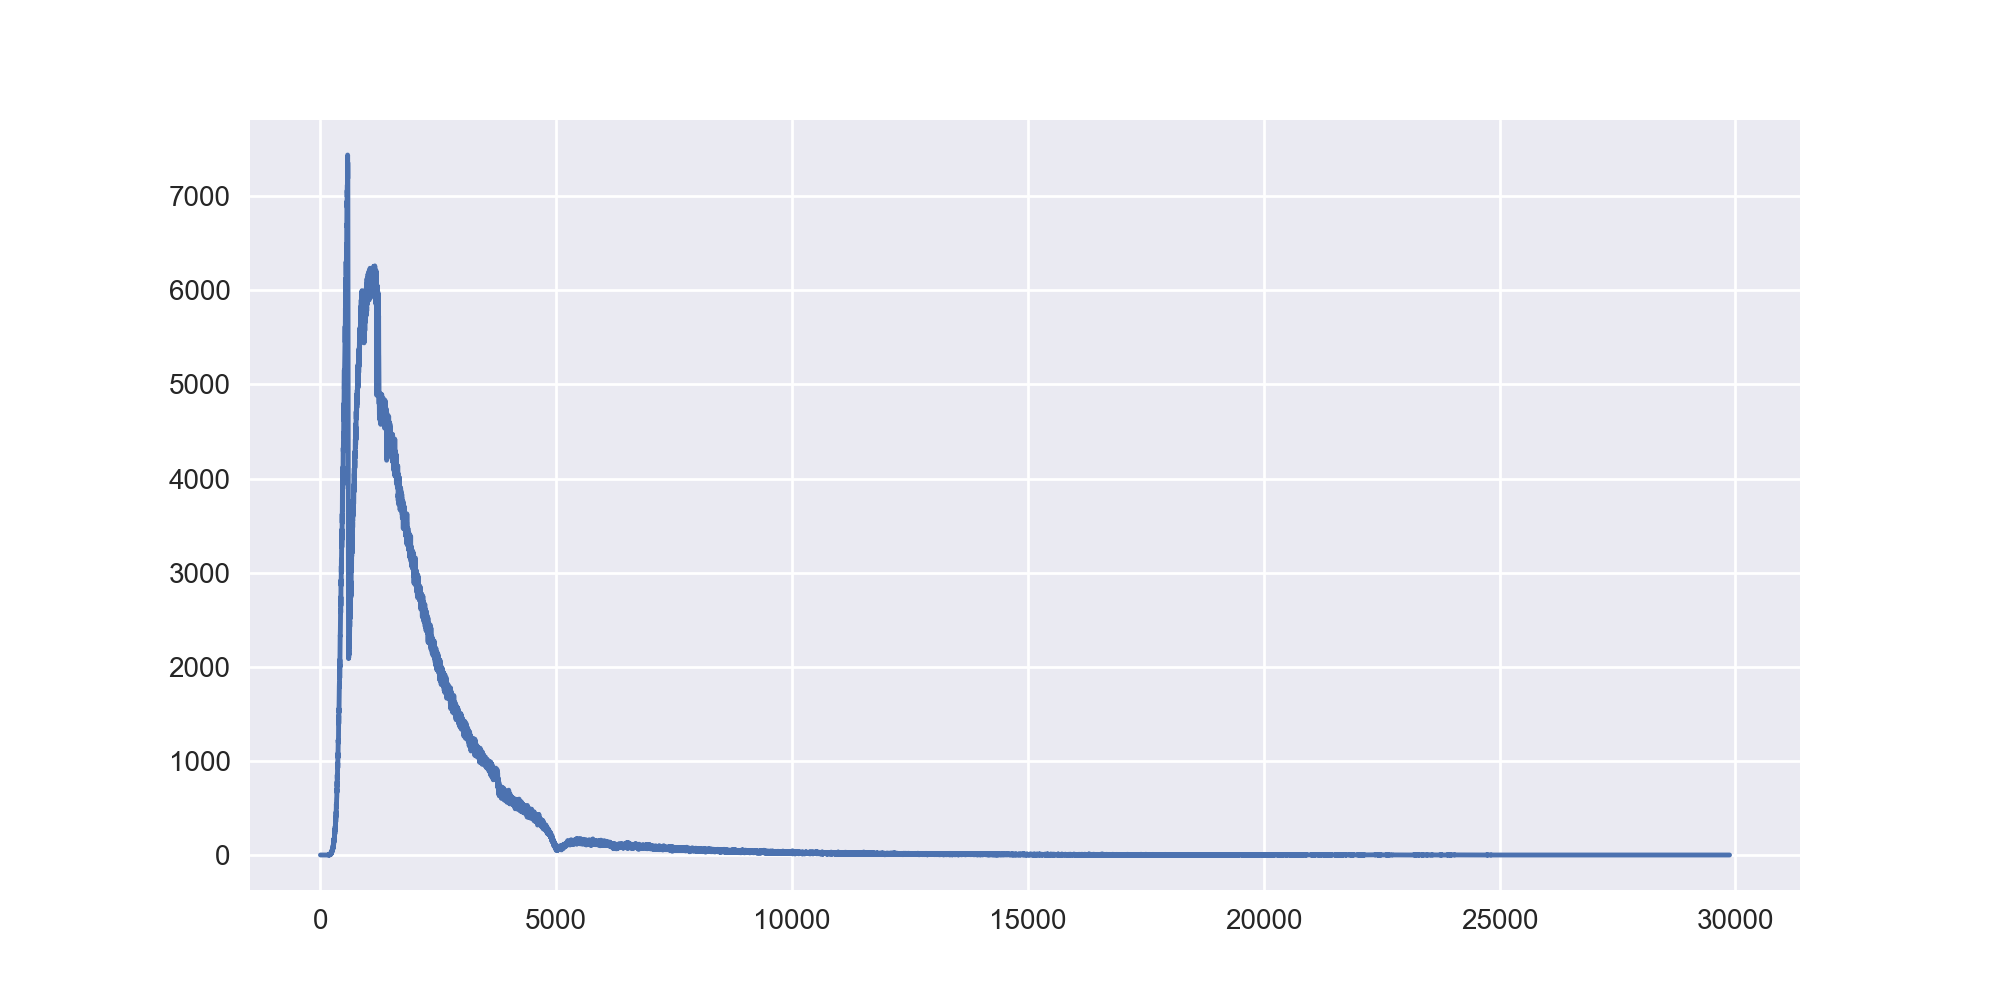

In [8]:
plt.figure(figsize=(10,5))
plt.plot(channel, counts)

Let's also load the ARF and RMF:

In [9]:
arf = ARF(datadir+arf_file)
rmf = RMF(datadir+rmf_file)

Let's make an empty model to divide out the responses:

In [10]:
resp_model = np.ones_like(counts)
m_arf = arf.apply_arf(resp_model)
m_rmf = rmf.apply_rmf(m_arf)

In [11]:
c_deconv = counts/m_rmf

<IPython.core.display.Javascript object>


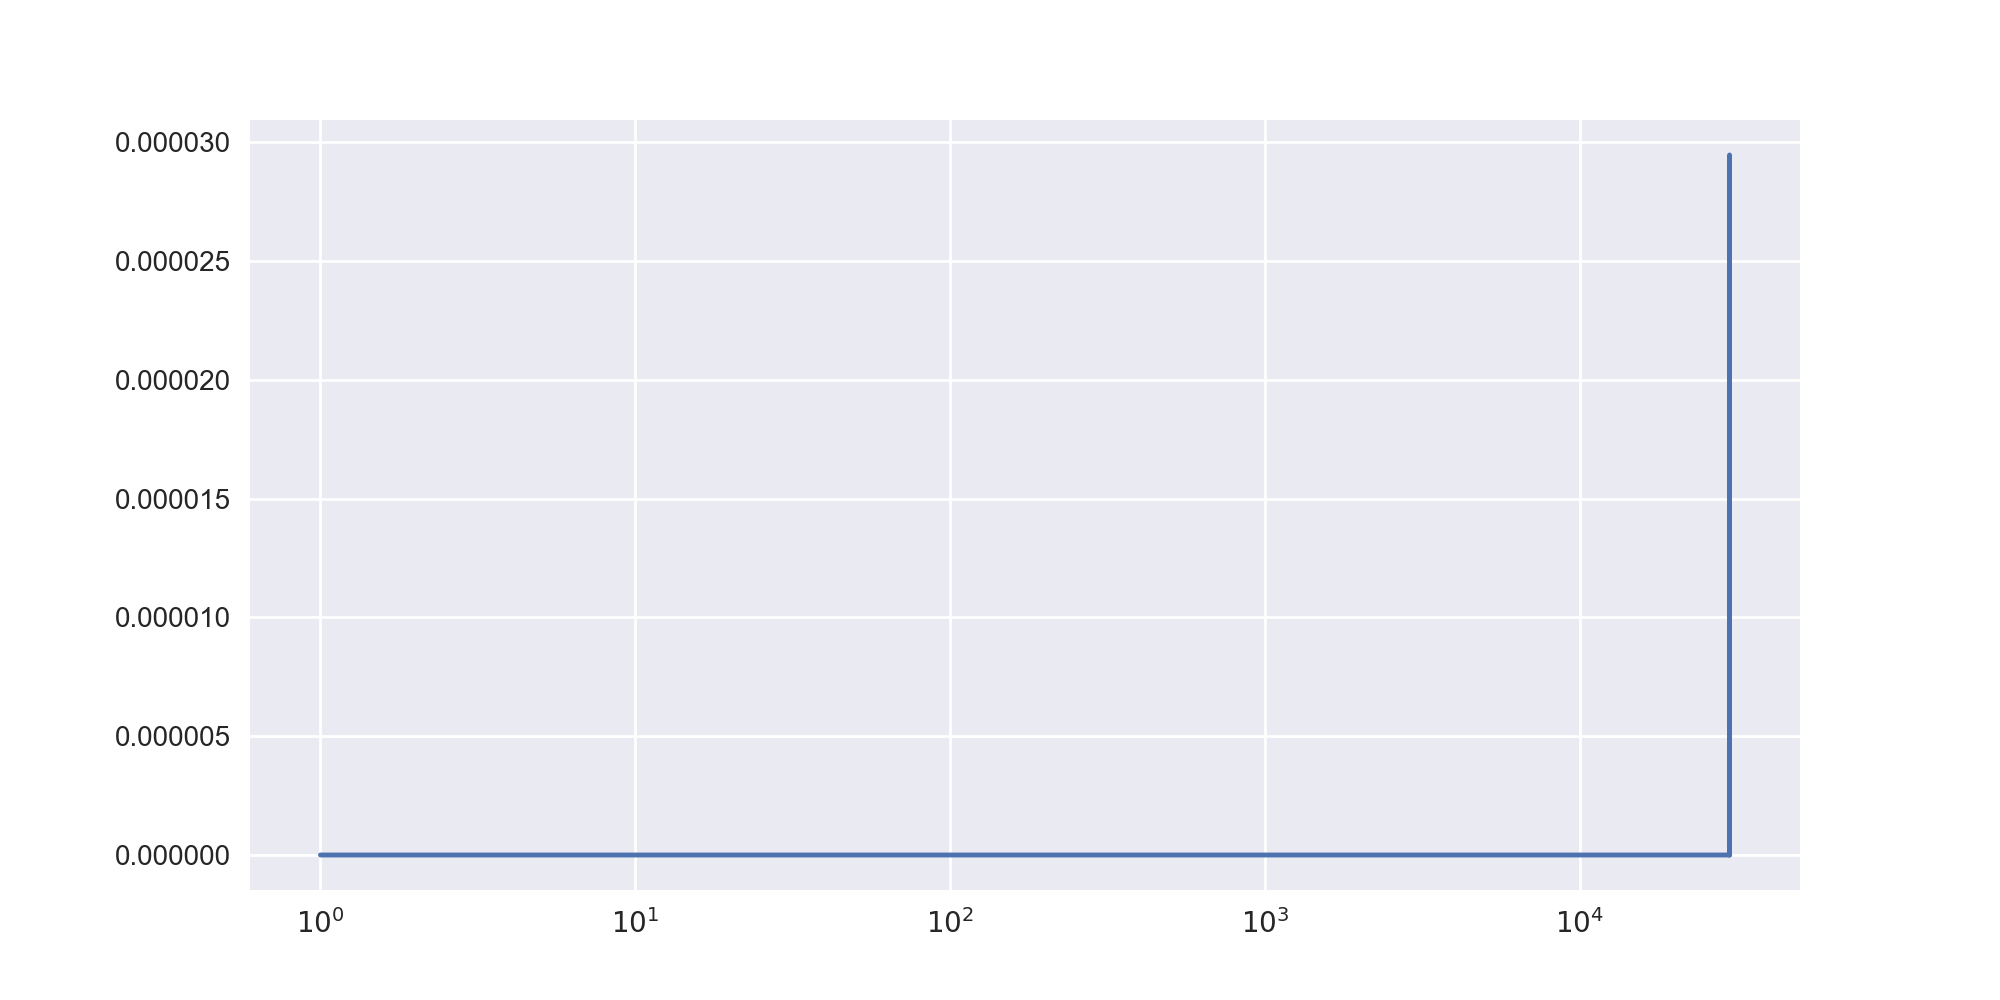

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(channel, c_deconv)
plt.xscale("log")

This seems to be working not badly. Let's try the same with sherpa:

In [13]:
ui.load_data("26", datadir+data_file)
d = ui.get_data("26")
arf_s = d.get_arf()
rmf_s = d.get_rmf()

read ARF file ../data/athena/athena_xifu_sixte_1469_onaxis_v20150402.arf


Do the ARF and RMF exist?

In [14]:
print("ARF: " + str(arf_s))
print("RMF: " + str(rmf_s))

ARF: name     = ../data/athena/athena_xifu_sixte_1469_onaxis_v20150402.arf
energ_lo = Float64[29874]
energ_hi = Float64[29874]
specresp = Float64[29874]
bin_lo   = None
bin_hi   = None
exposure = None
RMF: None


There's no RMF, because the RMF for Athena does not seem to be a variable length field and is thus not read in. Oh well.

Let's check whether at least the ARF is the same:

In [15]:
assert np.all(arf_s.specresp == arf.specresp), "Clarsach ARF is different from Sherpa ARF"

Looks like this worked. Let's do the deconvolution with sherpa and look at the results:

In [16]:
ui.set_source("26", ui.polynom1d.truespec)
c_deconv_s = ui.get_ratio_plot("26").y
e_deconv_s = ui.get_ratio_plot("26").x


<IPython.core.display.Javascript object>


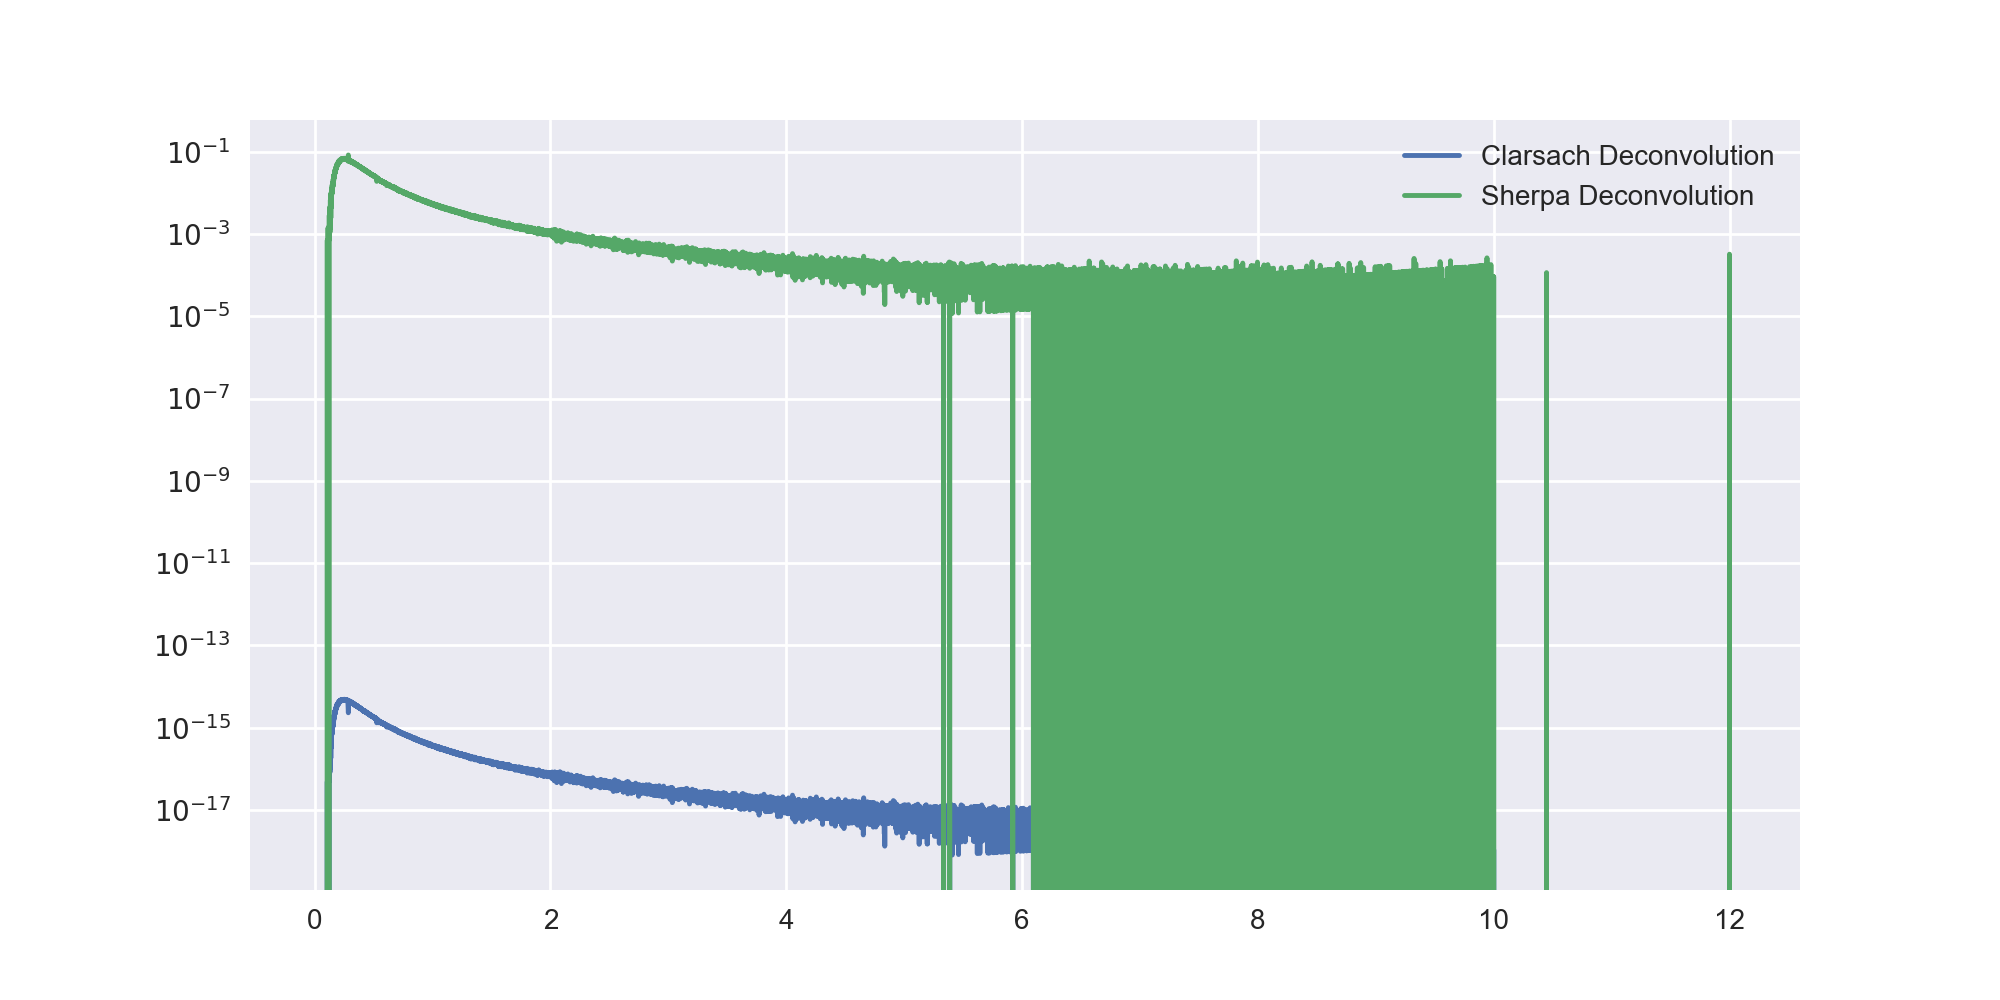

In [17]:
plt.figure(figsize=(10,5))
plt.plot(e_deconv_s, c_deconv, label="Clarsach Deconvolution")
plt.plot(e_deconv_s, c_deconv_s, label="Sherpa Deconvolution")
plt.legend()
plt.yscale('log')

In [18]:
np.allclose(c_deconv, c_deconv_s)

False

Well, I didn't actually expect them to be the same, so all right. This might also be due to the fact that I don't understand everything about what `ratio_plot` is doing; at some point I need to talk to Victoria about that.

# Modeling the Spectrum

I can't actually model the full spectrum right now, because I don't have the `XSPEC` models, thus I don't have the galactic absorption model. This'll have to wait to later. Let's take the second half of the spectrum and fit a model to it. For now, let's ignore the lines and just fit a basic power law:

In [19]:
import astropy.modeling.models as models
from astropy.modeling.fitting import _fitter_to_model_params
from scipy.special import gammaln as scipy_gammaln

In [20]:
pl = models.PowerLaw1D()

We'll need to fix the `x_0` parameter of the power law model to continue:

In [21]:
pl.x_0.fixed = True

Let's define a Poisson log-likelihood:

In [22]:
class PoissonLikelihood(object):
    
    def __init__(self, x, y, model, arf=None, rmf=None, bounds=None):
        self.x = x
        self.y = y
        self.model = model
        self.arf = arf
        self.rmf = rmf
        
        if bounds is None:
            bounds = [self.x[0], self.x[-1]]
        
        min_idx = self.x.searchsorted(bounds[0])
        max_idx = self.x.searchsorted(bounds[1])
        
        self.idx = [min_idx, max_idx]
        
    def evaluate(self, pars):
        # store the new parameters in the model
        _fitter_to_model_params(self.model, pars)

        # evaluate the model at the positions x
        mean_model = self.model(self.x)

        # run the ARF and RMF calculations
        if arf is not None and rmf is not None:
            m_arf = arf.apply_arf(mean_model)
            ymodel = rmf.apply_rmf(m_arf)
        else:
            ymodel = mean_model
        
        # cut out the part of the spectrum that's of interest
        y = self.y[self.idx[0]:self.idx[1]]
        ymodel = ymodel[self.idx[0]:self.idx[1]]
        
        # compute the log-likelihood
        loglike = np.sum(-ymodel + y*np.log(ymodel) \
               - scipy_gammaln(y + 1.))

        if np.isfinite(loglike):
            return loglike
        else:
            return -1.e16

    def __call__(self, pars):
        l = -self.evaluate(pars)
        #print(l)
        return l


Ok, cool, let's make a `PoissonLikelihood` object to use:

In [23]:
loglike = PoissonLikelihood(e_deconv_s, counts, pl, arf=arf, rmf=rmf, bounds=[1.0, 6.0])

In [24]:
loglike([1.0, 2.0])

9.2432699616724664e+21

Let's fit this with a minimization algorithm:

In [25]:
from scipy.optimize import minimize

In [26]:
opt = minimize(loglike, [1.0, 1.0])

In [27]:
opt

      fun: 1e+16
 hess_inv: array([[ 1.16600397,  0.54057102],
       [ 0.54057102,  0.25061409]])
      jac: array([ 0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([-2.40460942,  0.35693326])

Looks like it has accurately found the photon index of 2. Let's make a best-fit example model and plot the raw spectra:

In [28]:
_fitter_to_model_params(pl, opt.x)
mean_model = pl(loglike.x)

m_arf = arf.apply_arf(mean_model)
ymodel = rmf.apply_rmf(m_arf)

ymodel_small = ymodel[loglike.idx[0]:loglike.idx[1]]
y_small = loglike.y[loglike.idx[0]:loglike.idx[1]]
e_deconv_small = e_deconv_s[loglike.idx[0]:loglike.idx[1]]

print(np.mean(y_small-ymodel_small))

4.77806249409e+18


<IPython.core.display.Javascript object>


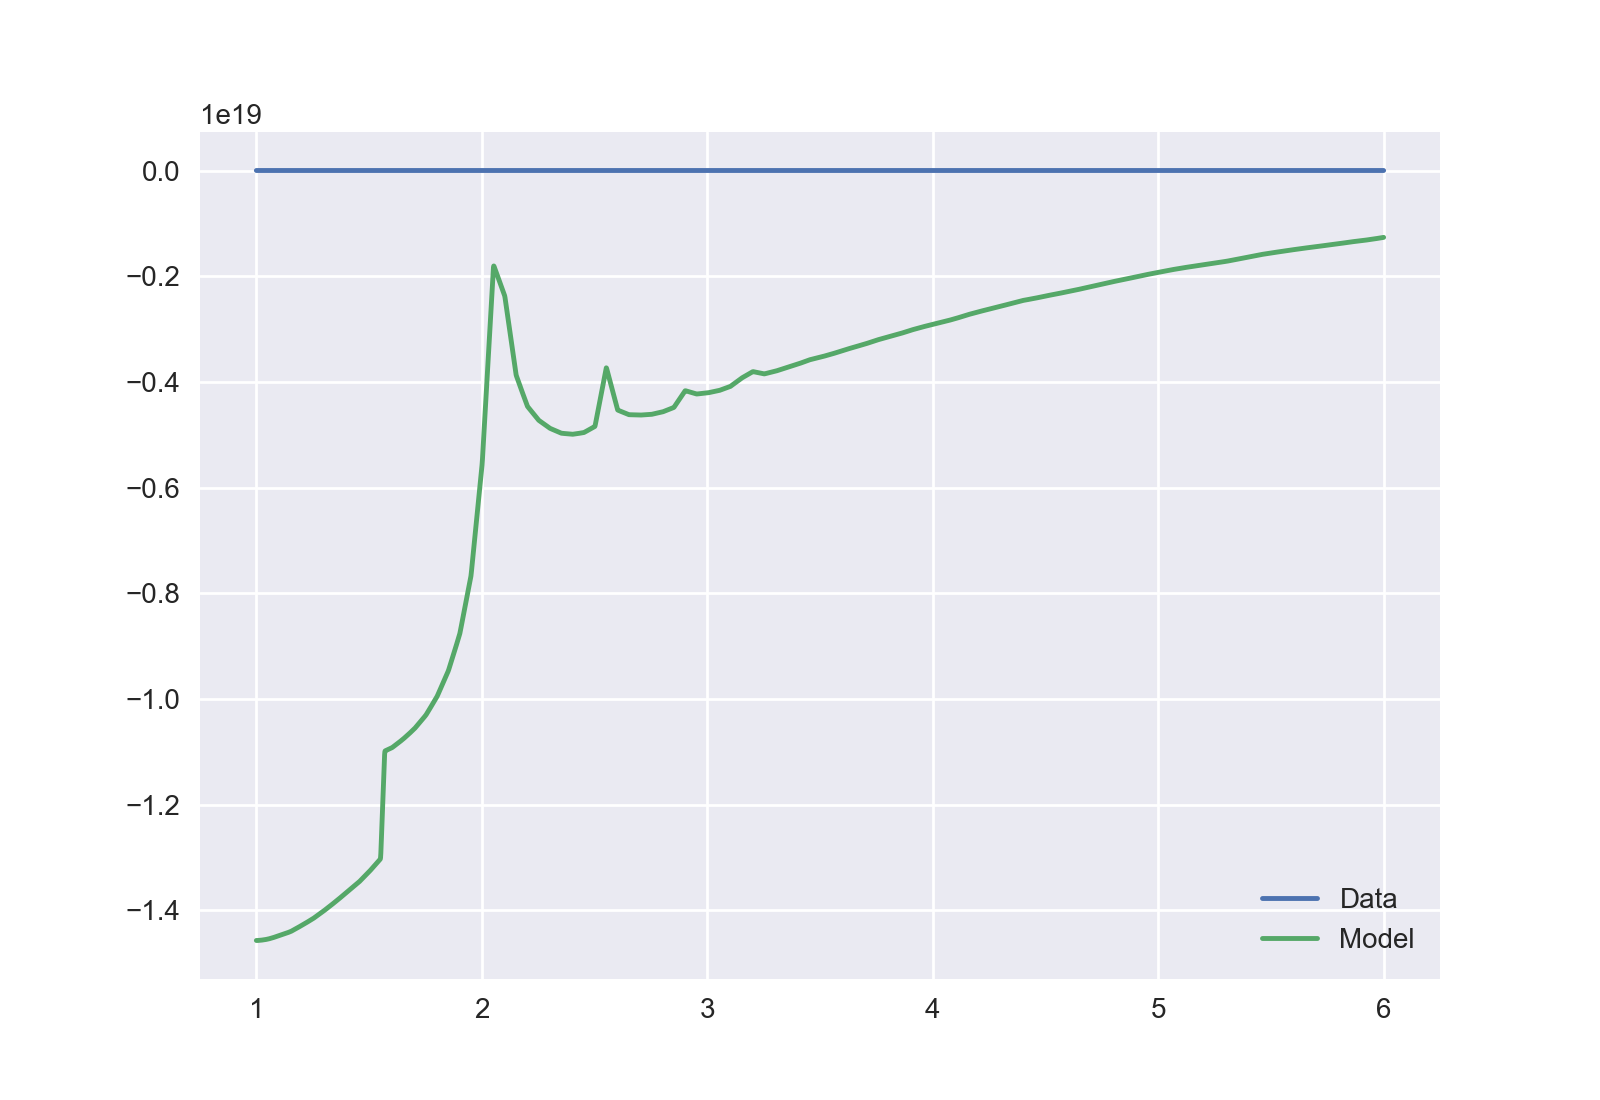

In [29]:
plt.figure()
plt.plot(e_deconv_small, y_small, label="Data")
plt.plot(e_deconv_small, ymodel_small, label="Model")
plt.legend()

Let's also plot the deconvolved version for fun:

<IPython.core.display.Javascript object>


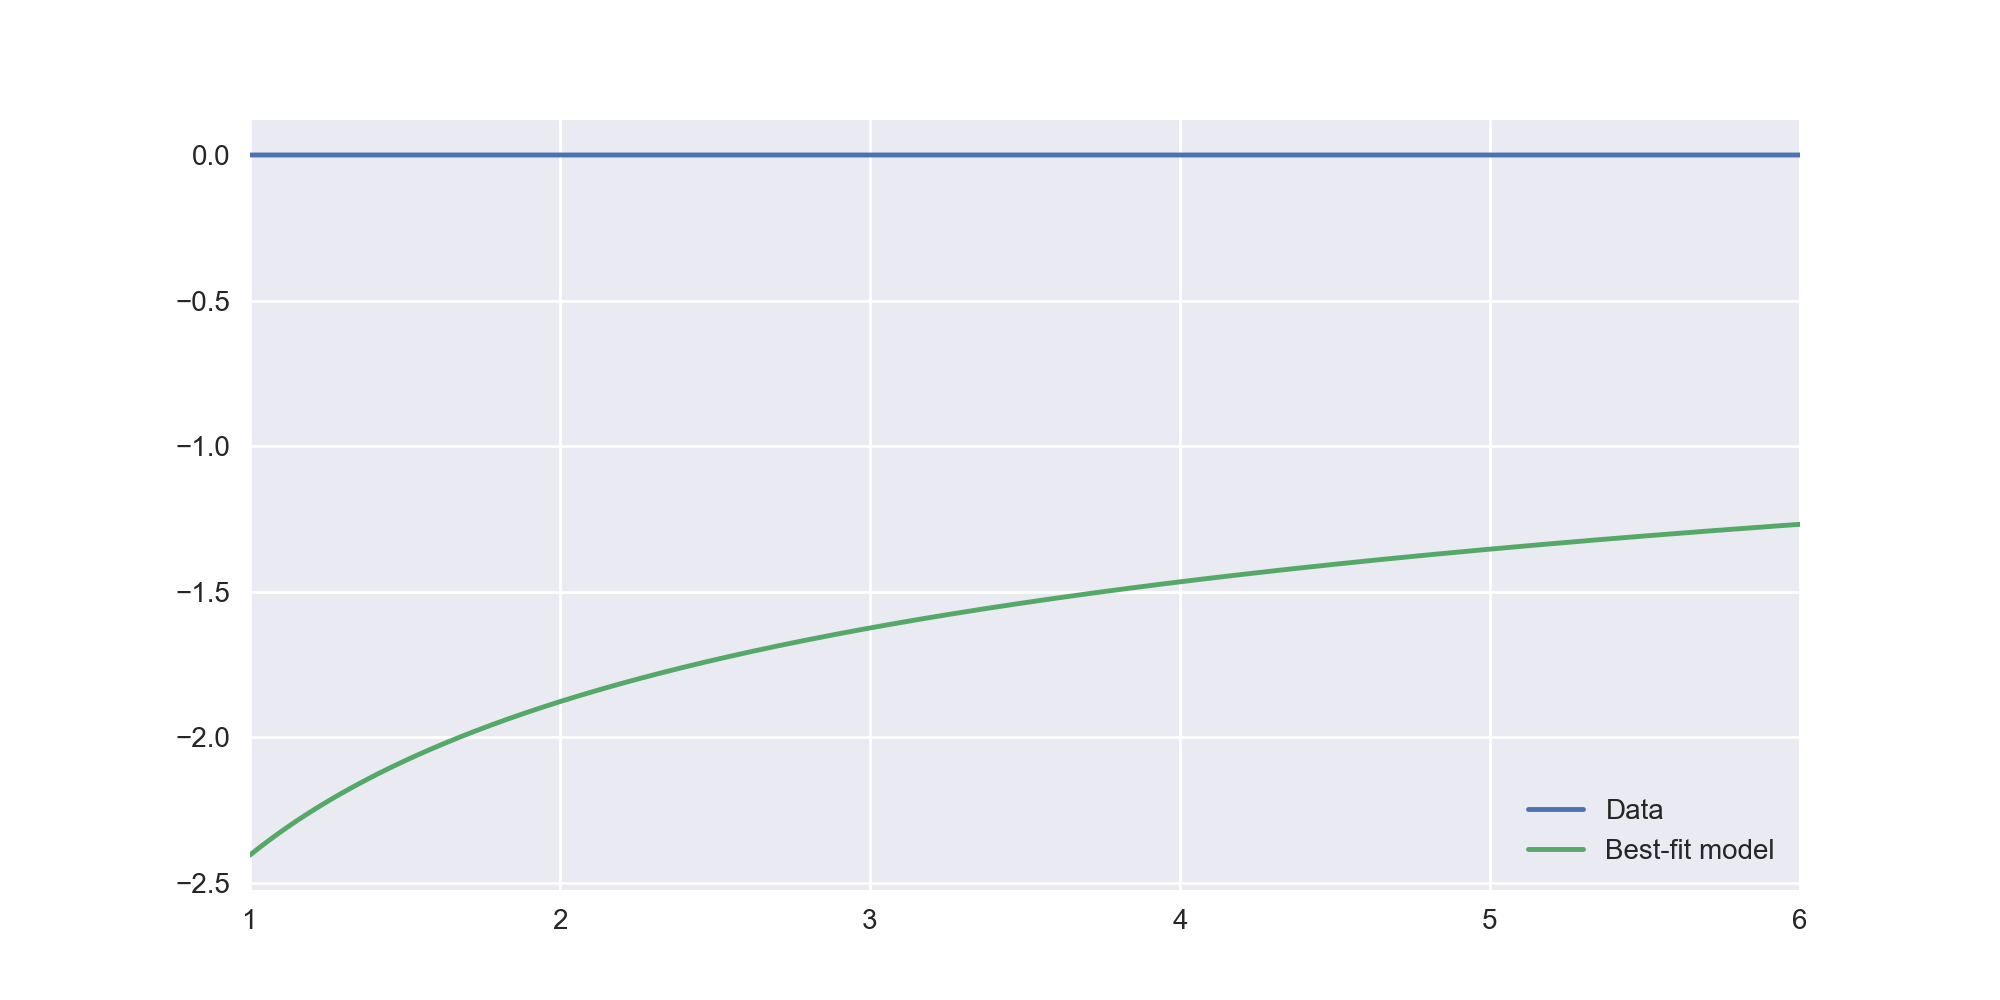

In [30]:
plt.figure(figsize=(10,5))
plt.plot(e_deconv_small, c_deconv[loglike.idx[0]:loglike.idx[1]], label="Data")
plt.plot(e_deconv_small, mean_model[loglike.idx[0]:loglike.idx[1]], label="Best-fit model")
plt.xlim(1.0, 6.0)

plt.legend()



It works! Next, I need to include XSPEC models, but that is a whole other can of worms ...